### Entropy Features

In [1]:
import pandas as pd
import numpy as np
from FinancialMachineLearning.features.entropy import *

In [2]:
import yfinance as yf

start_date = '1999-12-29'
end_date = '2024-02-09'
tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'PYPL', 'ADBE', 'INTC', 'CSCO', 'CMCSA', 'PEP', 'NFLX', 'COST', 'AMGN', 'AVGO', 'TXN', 'QCOM', 'GILD', 'SBUX'
]
price = pd.DataFrame()
for i in tickers :
    price = pd.concat([
        price, 
        yf.download(i, start=start_date, end=end_date)['Close']
    ], axis = 1)
price.columns = tickers
price.index = pd.to_datetime(price.index)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [3]:
from FinancialMachineLearning.features.microstructure import *

prices = price['AAPL']
tick_rule_classification = tick_rule(prices)

/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/features/microstructure.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aggressor = aggressor.fillna(method='ffill')


#### Shannon entropy

In [5]:
shannon_entropy = shannon_entropy(tick_rule_classification)

In [6]:
shannon_entropy

0.9985389384902732

#### Plug-in Entropy

In [7]:
plug_in = plug_in_entropy(tick_rule_classification)

In [8]:
plug_in

1.944490292068567

#### Lempel-Ziv Entropy

In [11]:
message_str = ''.join(str(e) for e in tick_rule_classification)
lz = lempel_ziv_entropy(message_str)

In [12]:
lz

0.05735140771637122

#### Kontoyiannis Entropy

In [15]:
konto = konto_entropy(message_str, window = 21)

In [16]:
konto

0.4428910423982824

#### Binary encoding

In [22]:
from FinancialMachineLearning.features.encoding import *

encoded_series = encode_tick_rule_array([i for i in tick_rule_classification.astype(int)])

In [24]:
plug_in_entropy(encoded_series)

0.998527726025453

#### Quantile encoding

In [25]:
quantile_dict = quantile_mapping([i for i in tick_rule_classification.astype(int)], num_letters = 21)

In [26]:
message = encode_array(tick_rule_classification.values, quantile_dict)

In [28]:
plug_in_entropy(message)

0.998527726025453

#### Sigma Encoding

In [44]:
sigma_dict = sigma_mapping(tick_rule_classification.values, step = 1)

In [45]:
message = encode_array(tick_rule_classification.values, sigma_dict)

In [46]:
plug_in_entropy(message)

0.998527726025453

In [49]:
discreteEntropy(message).konto(window = 21)

0.8367179476038419

In [50]:
discreteEntropy(message).lempel_ziv()

0.12658645129388496

In [64]:
sigma_dict_ms = sigma_mapping(
    tick_rule(price['MSFT']).values, step = 1
)

/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/features/microstructure.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aggressor = aggressor.fillna(method='ffill')


In [65]:
message_ms = encode_array(tick_rule(price['MSFT']).values, sigma_dict_ms)

/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/features/microstructure.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aggressor = aggressor.fillna(method='ffill')


In [66]:
plug_in_entropy(message_ms)

0.9995820855560466

In [67]:
plug_in_entropy(message)

0.998527726025453

In [69]:
cXY = np.histogram2d(price['AAPL'], price['MSFT'], 2)

In [70]:
cXY

(array([[5180.,    0.],
        [  68.,  819.]]),
 array([  0.234286  ,  99.1721433 , 198.11000061]),
 array([ 15.14999962, 214.62999249, 414.10998535]))

In [71]:
from sklearn.metrics import mutual_info_score
iXY = mutual_info_score(None, None, contingency = cXY[0])

In [72]:
iXY

0.3562148787794541

In [73]:
iXYn = iXY / min(plug_in_entropy(message_ms), plug_in_entropy(message))

In [74]:
iXYn

0.3567400979413305

In [75]:
hXY = plug_in_entropy(message_ms) + plug_in_entropy(message) - iXY
print(f"disjoint entropy : {hXY}")

disjoint entropy : 1.6418949328020456


In [76]:
hX_Y = hXY - plug_in_entropy(message) 
print(f"conditional entropy : {hX_Y}")

conditional entropy : 0.6433672067765925


In [77]:
hY_X = hXY - plug_in_entropy(message_ms) 
print(f"conditional entropy : {hY_X}")

conditional entropy : 0.642312847245999


In [101]:
from FinancialMachineLearning.metrics.distance import num_bins

def _entropy_estimator(x, y, method = 'tick_rule', encoding = 'sigma', measure = 'plug_in', window = 21) :
    b_xy = num_bins(len(x), np.corrcoef(x, y)[0,1])
    c_xy = np.histogram2d(x, y, b_xy)[0]
    i_xy = mutual_info_score(None, None, contingency = c_xy)
    
    if method == 'tick_rule' :
        method_x = tick_rule(x).values
        method_y = tick_rule(y).values
    elif method == 'ret' :
        method_x = x
        method_y = y
    
    if encoding == 'binary' :
        encoded_x = encode_tick_rule_array(method_x)
        encoded_y = encode_tick_rule_array(method_y)
    elif encoding == 'quantile' :
        quantile_dict_x = quantile_mapping([i for i in method_x.astype(int)], num_letters = window)
        quantile_dict_y = quantile_mapping([i for i in method_y.astype(int)], num_letters = window)
        encoded_x = encode_array(method_x, quantile_dict_x)
        encoded_y = encode_array(method_y, quantile_dict_y)
    elif encoding == 'sigma' :
        sigma_dict_x = sigma_mapping(method_x, step = window)
        sigma_dict_y = sigma_mapping(method_y, step = window)
        encoded_x = encode_array(method_x, sigma_dict_x)
        encoded_y = encode_array(method_y, sigma_dict_y)
        
    if measure == 'plug_in' :
        entropy_x = plug_in_entropy(encoded_x)
        entropy_y = plug_in_entropy(encoded_y)
    elif measure == 'lempel_ziv' :
        entropy_x = lempel_ziv_entropy(encoded_x)
        entropy_y = lempel_ziv_entropy(encoded_y)   
    elif measure == 'kontoyiannis' :
        entropy_x = konto_entropy(encoded_x, window = window)
        entropy_y = konto_entropy(encoded_y, window = window) 
    
    h_xy = entropy_x + entropy_y - i_xy
    
    return h_xy

def entropy_estimator(ret, method = 'tick_rule', encoding = 'sigma', measure = 'plug_in', window = 21) :
    n = len(ret.columns)
    dist = np.zeros((n,n))
    for i in range(n) :
        for j in range(n) :
            dist[i,j] = _entropy_estimator(ret.iloc[:,i], ret.iloc[:,j], method = method, encoding = encoding, measure = measure, window = window)
    dist = pd.DataFrame(dist, columns = ret.columns, index = ret.columns)
    return dist

In [86]:
ret = np.log(price.dropna() / price.dropna().shift(1)).dropna()

In [87]:
type(ret)

pandas.core.frame.DataFrame

In [91]:
import warnings
warnings.filterwarnings('ignore')
entropy = entropy_estimator(
    ret, 
    method = 'tick_rule', 
    encoding = 'sigma', 
    measure = 'plug_in', 
    window = 21
)

Text(0.5, 1.0, 'measure = plug_in | encoding = sigma | method = tick_rule')

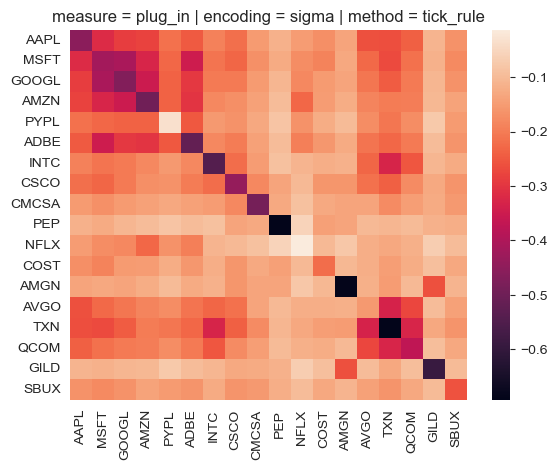

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(entropy)
plt.title('measure = plug_in | encoding = sigma | method = tick_rule')

In [95]:
entropy = entropy_estimator(
    ret, 
    method = 'tick_rule', 
    encoding = 'sigma', 
    measure = 'lempel_ziv', 
    window = 21
)

Text(0.5, 1.0, 'measure = lempel_ziv | encoding = sigma | method = tick_rule')

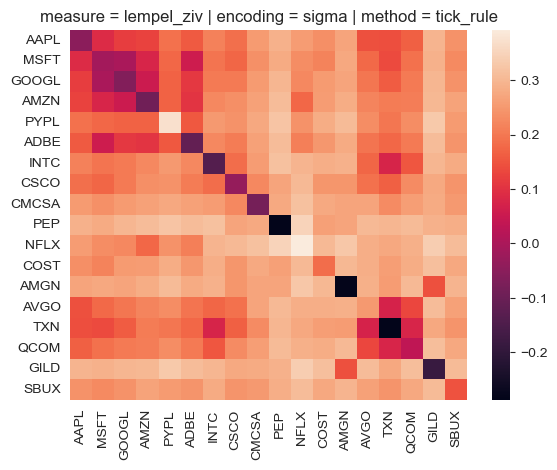

In [100]:
sns.heatmap(entropy)
plt.title('measure = lempel_ziv | encoding = sigma | method = tick_rule')

In [97]:
entropy = entropy_estimator(
    ret, 
    method = 'tick_rule', 
    encoding = 'sigma', 
    measure = 'kontoyiannis', 
    window = 21
)

Text(0.5, 1.0, 'measure = kontoyiannis | encoding = sigma | method = tick_rule')

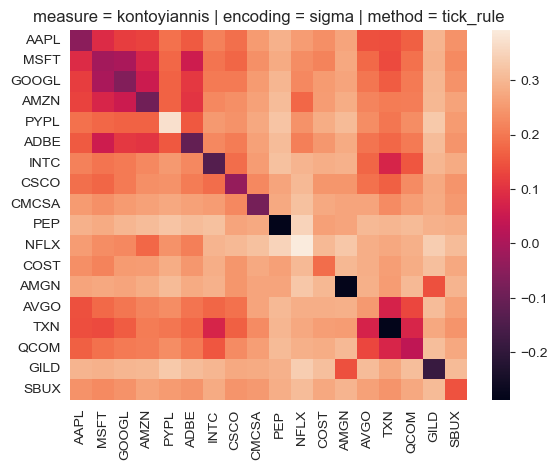

In [99]:
sns.heatmap(entropy)
plt.title('measure = kontoyiannis | encoding = sigma | method = tick_rule')

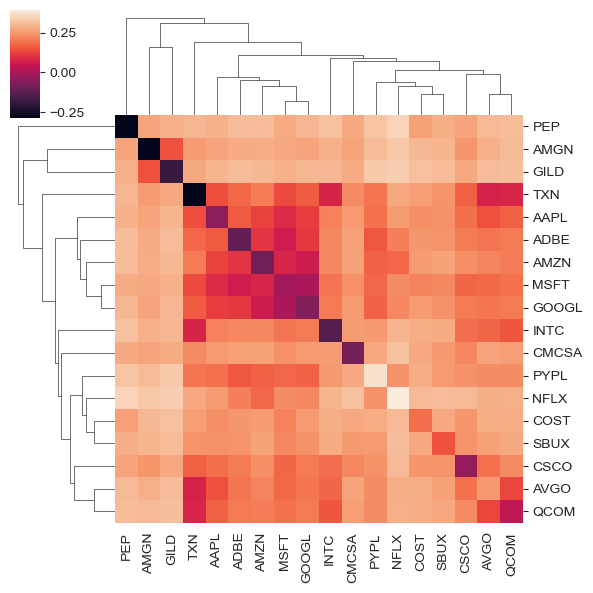

In [106]:
sns.clustermap(entropy, figsize = (6, 6))

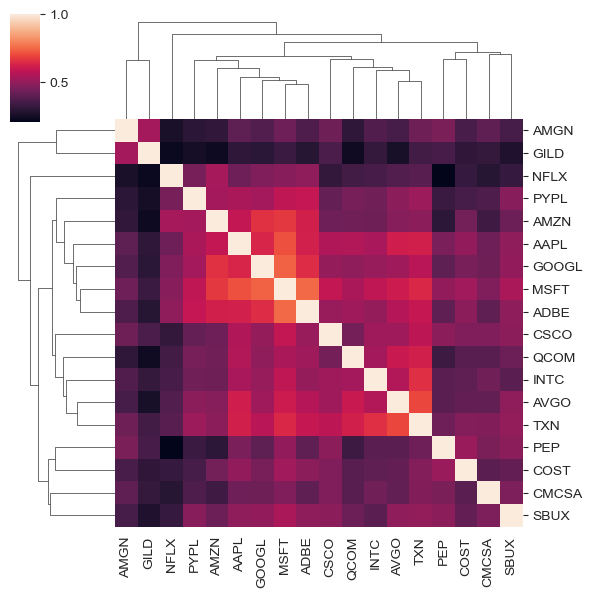

In [110]:
sns.clustermap(ret.corr(), figsize = (6, 6))

conclusion : entropy는 correlation을 대체하는 척도로서 사용이 가능하다